In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

import glob

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# make annual maps for each period

In [2]:
root_path = '/Users/willatobin/Documents/SIO/ClimateBench2/backend/paleo_data_cache'
# eocene
eocene_models = glob.glob(f'{root_path}/deepmip/dap.ceda.ac.uk/badc/cmip6/data/CMIP6Plus/DeepMIP/deepmip-eocene-p1/*/*/*-x*/*/climatology/*')

# pliocene
pliocene_models = glob.glob(f'{root_path}/*/midPliocene-eoi400_tas_annual.nc')
# lig127k
lig127k_models = glob.glob(f'{root_path}/*/lig127k_tas_annual.nc')
# LGM
lgm_models = glob.glob(f'{root_path}/*/lgm_tas_annual.nc')
# midH
midHolocene_models = glob.glob(f'{root_path}/*/midHolocene_tas_annual.nc')

In [ ]:
# period = 'eocene'
# for file in eocene_models:
#     model = file.split('/')[17]
#     co2 = file.split('/')[18].split('-')[-1]

#     ds = xr.open_dataset(file)
    
#     if "t" in ds.dims:
#         ds = ds.rename({'t':'time','latitude':'lat','longitude':'lon'})
#     if "time_counter" in ds.dims:
#         ds = ds.rename({'time_counter':'time'})
    
#     ds = ds.mean(dim='time')

#     fig, axis = plt.subplots(1, 1, figsize=(9,5),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

#     cax = (ds['tas'] - 273.15).plot(
#         ax=axis,transform=ccrs.PlateCarree(), 
#         vmin = -60,
#         vmax = 60,
#         cmap = 'RdBu_r',
#         add_colorbar=False
#     )
#     cbar = fig.colorbar(cax, ticks=[-60,-30, 0, 30,60])
#     axis.coastlines()  # cartopy function

#     axis.set_title(f"{model} CO2{co2}",fontsize=20)

#     os.makedirs(f'results/paleo/{period}_maps',exist_ok=True)
#     fig.savefig(f'results/paleo/{period}_maps/{model}_{co2}.png', bbox_inches='tight', pad_inches=0.1)

In [ ]:
# period = 'pliocene' # run this for each non eocene period
# for file in pliocene_models:
#     model = file.split('/')[8]

#     ds = xr.open_dataset(file)

#     fig, axis = plt.subplots(1, 1, figsize=(9,5),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

#     cax = (ds['tas'] - 273.15).plot(
#         ax=axis,transform=ccrs.PlateCarree(), 
#         vmin = -60,
#         vmax = 60,
#         cmap = 'RdBu_r',
#         add_colorbar=False
#     )
#     cbar = fig.colorbar(cax, ticks=[-60,-30, 0, 30,60])
#     axis.coastlines()  # cartopy function

#     axis.set_title(model,fontsize=20)

#     os.makedirs(f'results/paleo/{period}_maps',exist_ok=True)
#     fig.savefig(f'results/paleo/{period}_maps/{model}.png', bbox_inches='tight', pad_inches=0.1)

for seasonal plots, do zonal means and make csv.

In [16]:
df = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip6.csv")
piC_tas_df = df[(df['activity_id'] == 'CMIP') & (df['experiment_id'] == 'piControl')& (df['table_id'] == 'Amon')& (df['variable_id'] == 'tas')]#['table_id'].unique()

piC_eocene = glob.glob(f'{root_path}/deepmip/dap.ceda.ac.uk/badc/cmip6/data/CMIP6Plus/DeepMIP/deepmip-eocene-p1/*/*/*-PI/*/climatology/*')

In [ ]:
### MONTHLY AVERAGES FOR EVERY MODEL AND TIME PERIOD ####
regions = {
    'global':[-90,90],
    'northern_hemisphere':[0,90],
    'tropics':[-30,30],
    'southern_hemisphere':[-90,0],
}

monthly_files = glob.glob(f'{root_path}/*/*_tas_monthly.nc')
_results = []

for region, bnds in regions.items():
    for file in monthly_files:
        model = file.split('/')[8]
        period = file.split('/')[9].split('_')[0]

        ds = xr.open_dataset(file)
    
        ds_slice = ds.sel(lat = slice(bnds[0],bnds[1]))
        ds_zmean = ds_slice['tas'].weighted(ds_slice['weight'].fillna(0)).mean(dim=['lat','lon'])

        # get pi control to calculate anomaly
        piC_ds = xr.open_zarr(piC_tas_df[piC_tas_df['source_id'] == model].iloc[0]['zstore'],chunks={})
        piC_zmean = piC_ds.sel(lat = slice(bnds[0],bnds[1]))['tas'].weighted(ds_slice['weight'].fillna(0)).mean(dim=['lat','lon'])
        piC_zmean = piC_zmean.groupby('time.month').mean()
        
        df_zmean = ds_zmean.to_dataframe().reset_index()
        df_zmean = df_zmean.merge(piC_zmean.to_dataframe().reset_index()[['month','tas']].rename(columns={'tas':'tas_pi'}),on='month')

        df_zmean['model'] = model
        df_zmean['period'] = period
        df_zmean['region'] = region
        df_zmean['co2_exp'] = np.nan
        _results.append(df_zmean)

    for file in eocene_models:
        model = file.split('/')[17]
        co2 = file.split('/')[18].split('-')[-1]
        pi_file = [x for x in piC_eocene if model in x]

        ds = xr.open_dataset(file)
        ds_pi = xr.open_dataset(pi_file[0])
        
        if "t" in ds.dims:
            ds = ds.rename({'t':'time','latitude':'lat','longitude':'lon'})
            ds_pi = ds_pi.rename({'t':'time','latitude':'lat','longitude':'lon'})
        if "time_counter" in ds.dims:
            ds = ds.rename({'time_counter':'time'})
            ds_pi = ds_pi.rename({'time_counter':'time'})

        ds = ds.sortby('lat')
        ds_pi = ds_pi.sortby('lat')
        
        ds = ds.groupby('time.month').mean()
        ds_pi = ds_pi.groupby('time.month').mean()

        ds_slice = ds.sel(lat = slice(bnds[0],bnds[1]))
        ds_pi_slice = ds_pi.sel(lat = slice(bnds[0],bnds[1]))

        weights = np.cos(np.deg2rad(ds_slice.lat))
        weights = weights.expand_dims({"lon": ds_slice.lon})

        ds_zmean = ds_slice['tas'].weighted(weights.fillna(0)).mean(dim=['lat','lon'])
        ds_pi_zmean = ds_pi_slice['tas'].weighted(weights.fillna(0)).mean(dim=['lat','lon'])

        df_zmean = ds_zmean.to_dataframe().reset_index()
        df_zmean = df_zmean.merge(ds_pi_zmean.to_dataframe().reset_index()[['month','tas']].rename(columns={'tas':'tas_pi'}),on='month')

        df_zmean['model'] = model
        df_zmean['period'] = 'eocene'
        df_zmean['region'] = region
        df_zmean['co2_exp'] = co2
        _results.append(df_zmean)

seasonal_paleo_results = pd.concat(_results)
# seasonal_paleo_results[(seasonal_paleo_results['period'] == 'lig127k') & (seasonal_paleo_results['region'] == 'global')].pivot_table(index='month',columns='model',values = 'tas').plot()

/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_85352/2736516945.py:23: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  piC_ds = xr.open_zarr(piC_tas_df[piC_tas_df['source_id'] == model].iloc[0]['zstore'],chunks={})
/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_85352/2736516945.py:23: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  piC_ds = xr.open_zarr(piC_tas_df[piC_tas_df['source_id'] == model].iloc[0]['zstore'],chunks={})
/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_85352/2736516945.py:23: SerializationWarning: Unable to decode 

In [53]:
seasonal_paleo_results['tas_anom'] = seasonal_paleo_results['tas'] - seasonal_paleo_results['tas_pi']
seasonal_obs = pd.read_csv('observational_data/paleo/processed/monthly_mean_zonal_obs.csv').drop(columns=['Unnamed: 0'])
seasonal_obs['period'] = 'lgm'
seasonal_obs = seasonal_obs[['month','period','region','mean temperature [degreesC]']].rename(columns={'mean temperature [degreesC]':'tas_obs'})
monthly_zonal_means = seasonal_paleo_results.merge(seasonal_obs,on=['month','period','region'],how='outer')
monthly_zonal_means['mae'] = (monthly_zonal_means['tas_anom'] - monthly_zonal_means['tas_obs']).abs()
monthly_zonal_means.drop(columns=['height']).to_csv('results/paleo/monthly_zonal_means.csv')

In [6]:
### ANNUAL AVERAGES FOR EVERY MODEL AND TIME PERIOD ####

df = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip6.csv")
piC_tas_df = df[(df['activity_id'] == 'CMIP') & (df['experiment_id'] == 'piControl')& (df['table_id'] == 'Amon')& (df['variable_id'] == 'tas')]#['table_id'].unique()

annual_files = glob.glob(f'{root_path}/*/*_tas_annual.nc')
_results = []

for file in annual_files:
    model = file.split('/')[8]
    period = file.split('/')[9].split('_')[0]

    ds = xr.open_dataset(file)

    # get pi control to calculate anomaly
    piC_ds = xr.open_zarr(piC_tas_df[piC_tas_df['source_id'] == model].iloc[0]['zstore'],chunks={})
    ds_anom = ds - piC_ds.mean(dim='time').drop_vars(['height','lat_bnds','lon_bnds','time_bnds'],errors='ignore')

    ds_zmean = ds_anom['tas'].weighted(ds['weight'].fillna(0)).mean(dim=['lat','lon'])

    df_zmean = pd.DataFrame({
        'tas':[ds_zmean.values.tolist()],
        'model':[model],
        'period':[period],
        'region':['global'],
    })
    _results.append(df_zmean)

annual_paleo_results = pd.concat(_results)

annual_paleo_results['Time Period idx'] = 1
annual_paleo_results.loc[annual_paleo_results['period'] == 'lig127k','Time Period idx'] = 2
annual_paleo_results.loc[annual_paleo_results['period'] == 'lgm','Time Period idx'] = 3
annual_paleo_results.loc[annual_paleo_results['period'] == 'midHolocene','Time Period idx'] = 4


# get eocene annual results
eeco_files = glob.glob('/Users/willatobin/Documents/SIO/ClimateBench2/backend/paleo_data_cache/deepmip/dap.ceda.ac.uk/badc/cmip6/data/CMIP6Plus/DeepMIP/deepmip-eocene-p1/*/*/*/*/*/*')

eeco_models_df = pd.concat([
    pd.DataFrame(eeco_files).rename(columns={0:'local_path'}),
    pd.DataFrame(eeco_files)[0].str.split('/',expand=True)[[17,18]].rename(columns={17:'model',18:'experiment'})
],axis=1)

eeco_models_df['experiment_id'] = eeco_models_df['experiment'].str[-1]
eeco_models_df.loc[eeco_models_df['experiment_id'] == 'I','experiment_id'] = 0
eeco_models_df['experiment_id'] = eeco_models_df['experiment_id'].astype(int)

eeco_exp_models = eeco_models_df[~(eeco_models_df['experiment_id'] == 0)]  

_results = []
for row in eeco_exp_models.itertuples(index=False):
    model = row.model
    eeco_path = row.local_path
    pi_path = eeco_models_df[(eeco_models_df['model'] == model) & (eeco_models_df['experiment_id'] == 0)].iloc[0]['local_path']

    ds_piC = xr.open_dataset(pi_path,chunks={},decode_times=False)
    ds_eeco = xr.open_dataset(eeco_path,chunks={},decode_times=False)


    if "t" in ds_piC.dims:
        ds_piC = ds_piC.rename({'t':'time','latitude':'lat','longitude':'lon'})
        ds_eeco = ds_eeco.rename({'t':'time','latitude':'lat','longitude':'lon'})
    if "time_counter" in ds_piC.dims:
        ds_piC = ds_piC.rename({'time_counter':'time'})
        ds_eeco = ds_eeco.rename({'time_counter':'time'})

    ds_piC = ds_piC.mean(dim='time').drop_vars(['height','lat_bnds','lon_bnds'],errors='ignore')
    ds_eeco = ds_eeco.mean(dim='time').drop_vars(['height','lat_bnds','lon_bnds'],errors='ignore')

    ds_anom = ds_eeco - ds_piC

    weights = np.cos(np.deg2rad(ds_anom.lat))
    weights = weights.expand_dims({"lon": ds_anom.lon})
    weights.name = 'areacella'

    zmean = ds_anom.weighted(weights.fillna(0)).mean().compute()

    df_zmean = pd.DataFrame({
        'tas':[zmean['tas'].values.tolist()],
        'model':[model],
        'period':['eocene'],
        'region':['global'],
        'co2_exp':[row.experiment_id],
    })
    _results.append(df_zmean)
annual_eocene_results = pd.concat(_results)
annual_eocene_results['Time Period idx'] = 0

annual_paleo_results = pd.concat([
    annual_eocene_results,
    annual_paleo_results
])

/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_85352/2753333000.py:16: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  piC_ds = xr.open_zarr(piC_tas_df[piC_tas_df['source_id'] == model].iloc[0]['zstore'],chunks={})
/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_85352/2753333000.py:16: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  piC_ds = xr.open_zarr(piC_tas_df[piC_tas_df['source_id'] == model].iloc[0]['zstore'],chunks={})
/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_85352/2753333000.py:16: SerializationWarning: Unable to decode 

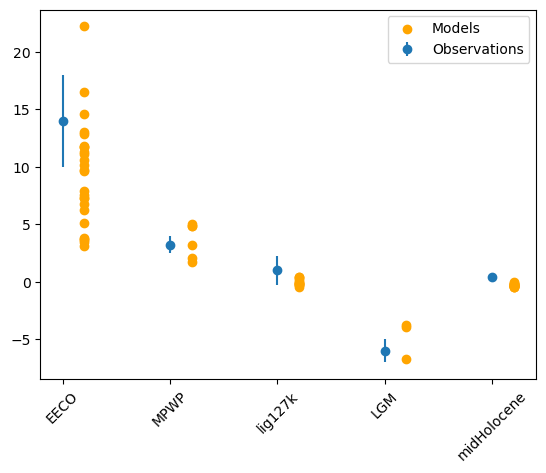

In [ ]:
# replicate IPCC fig 7.19
paleo_sat_avgs = pd.read_csv('observational_data/paleo/processed/annual_mean_global_obs.csv')

fig, ax = plt.subplots()

ax.errorbar(np.arange(1,6), paleo_sat_avgs['mean temperature [degreesC]'], yerr=paleo_sat_avgs['error [degreesC]'], fmt='o',label='Observations')
plt.scatter(x=annual_paleo_results['Time Period idx'] + 1.2,y=annual_paleo_results['tas'],label='Models',color='orange')

ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(paleo_sat_avgs['Time Period'],rotation=45);
ax.legend()

In [51]:
annual_paleo_obs = paleo_sat_avgs.rename(columns={'Time Period':'period','mean temperature [degreesC]':'tas_obs'})[['period','tas_obs']]
annual_paleo_obs['period'] = ['eocene','midPliocene-eoi400','lig127k','lgm','midHolocene']

mae_results = annual_paleo_results.rename(columns={'tas':'tas_anom'}).merge(annual_paleo_obs)
mae_results['mae'] = (mae_results['tas_anom'] - mae_results['tas_obs']).abs()
mae_results.to_csv('/Users/willatobin/Documents/SIO/ClimateBench2/backend/results/paleo/annual_zonal_means.csv')